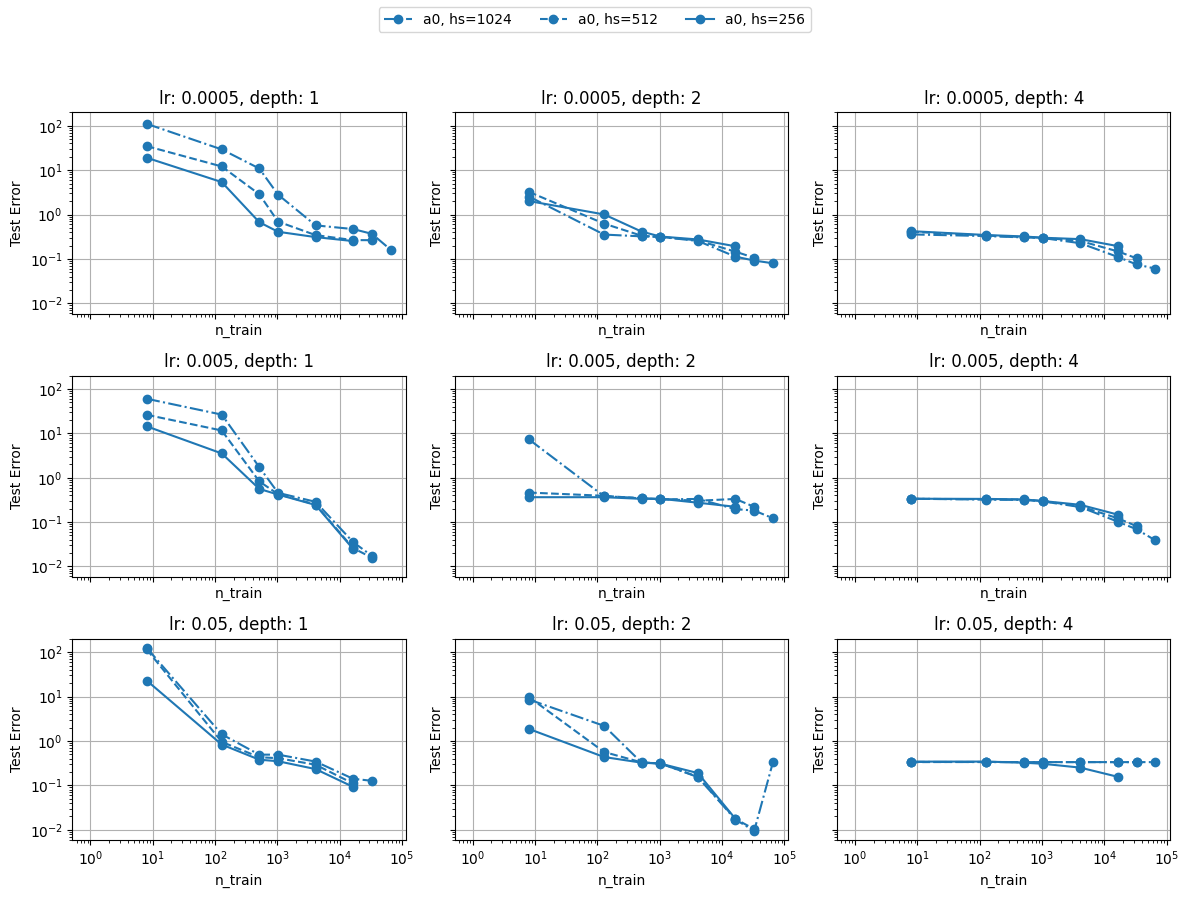

In [7]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_mup_depth_1"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "*_results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


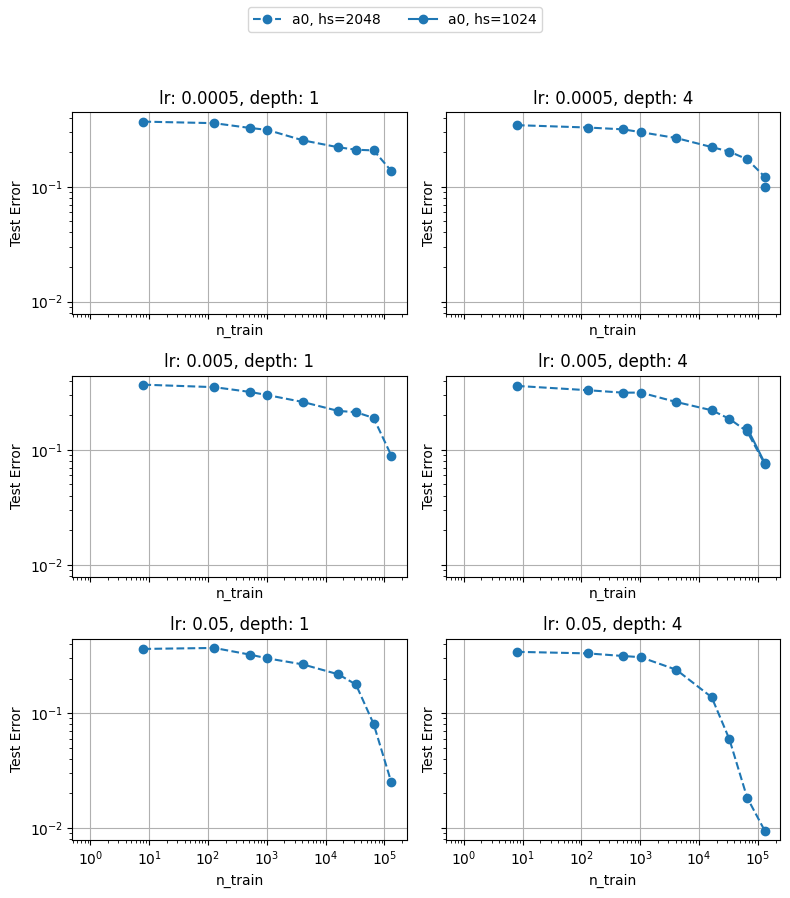

In [6]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_standard_depth_mpi"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


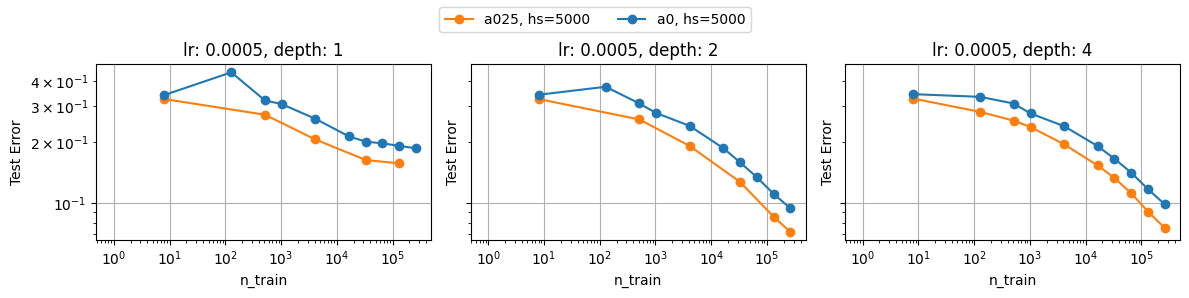

In [8]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_NTKjax_depth_1"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "*_results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


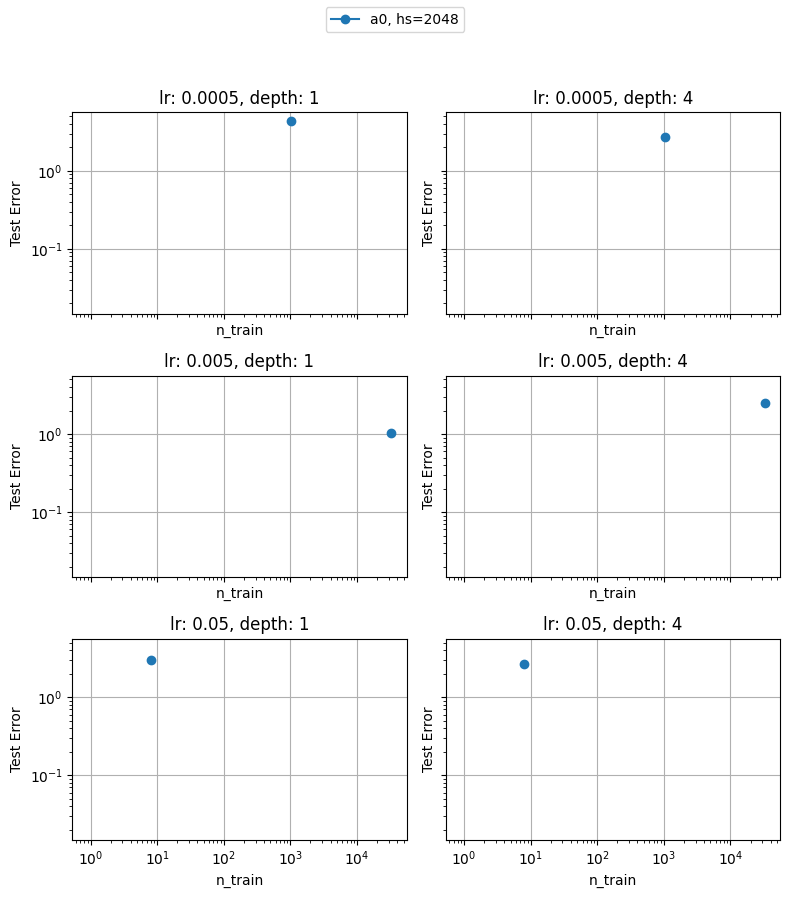

In [3]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_mup_2102"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()
